### BCI Competition 2008 相関行列の検定
今回は1人の被験者に絞って検定してみました

脳波解析用のモジュール[MNE-Python](https://martinos.org/mne/stable/index.html)をインストール


In [1]:
import pandas as pd
import numpy as np
from scipy.signal import correlate
from scipy.stats import zscore, norm
from statsmodels.sandbox.stats.multicomp import multipletests
import matplotlib.pyplot as plt
%matplotlib inline
import mne
mne.__version__

'0.14'

In [2]:
event_id = dict(left_hand=1, right_hand=2, feet=3, tongue=4)  # event ID

epoch作成用の情報を入力

In [3]:
fs = 250 # Sampling frequency
info = mne.create_info(["ch"+str(i) for i in range(25)], fs) #  Channel labels and sampling freq.

In [4]:
events = pd.read_csv('./datasets/events_A01T.csv', header=None)
events = np.array(events.astype(int))

In [5]:
# It takes a while
eegs = pd.read_csv('./datasets/eeg_A01T.csv', header=None)

In [6]:
raw = mne.io.array.RawArray(eegs, info)

Creating RawArray with float64 data, n_channels=25, n_times=677145
    Range : 0 ... 677144 =      0.000 ...  2708.576 secs
Ready.


In [7]:
epochs = mne.Epochs(raw, events, event_id, tmin=0.0, tmax=6.0, baseline=(None,0), preload=True, add_eeg_ref=False)

336 matching events found
0 projection items activated
Loading data for 336 events and 1501 original time points ...
0 bad epochs dropped


In [8]:
epochs

<Epochs  |  n_events : 336 (all good), tmin : 0.0 (s), tmax : 6.0 (s), baseline : (None, 0), ~96.2 MB, data loaded,
 'feet': 84, 'left_hand': 84, 'right_hand': 84, 'tongue': 84>

In [9]:
np.shape(epochs)
# trial, ch, time

(336, 25, 1501)

信号処理における[相互相関係数](https://bsd.neuroinf.jp/wiki/%E7%9B%B8%E4%BA%92%E7%9B%B8%E9%96%A2%E8%A7%A3%E6%9E%90)

In [10]:
def make_connection_matrix(epochs):
    ch_num = 22
    trial_num = 84
    cm_dict = {(trial, ch1, ch2): max(correlate(zscore(epochs[trial, ch1,:]), zscore(epochs[trial, ch2, :]))) for ch1 in range(ch_num) for ch2 in range(ch_num) for trial in range(trial_num) }
    #convert dictionary to ndarray
    cm =np.array([[[cm_dict[(trial, ch1, ch2)] for ch2 in range(ch_num)] for ch1 in range(ch_num)] for trial in range(trial_num)])
    # Normalized connection matrix (3D np.array)
    # cm_normed = np.array([(cm[trial, :, :] - cm[trial, :, :].min(0)) / cm[trial, :, :].ptp(0) for trial in range(trial_num)])
    # 上の式だと相関行列が対角線に関して対象にならないので以下のように修正
    cm_normed = np.array([(cm[trial, :, :] - cm[trial, :, :].min()) / cm[trial, :, :].ptp() for trial in range(trial_num)])
    return cm_normed

### 左手イメージ課題

In [11]:
# 3秒〜5秒間をimagery時の脳波として取り出す
cm = make_connection_matrix(epochs['left_hand'].get_data()[:,0:22,750:1250])
# 0秒〜2秒間をcue前の脳波として取り出す
cm_pre = make_connection_matrix(epochs['left_hand'].get_data()[:,0:22,0:500])

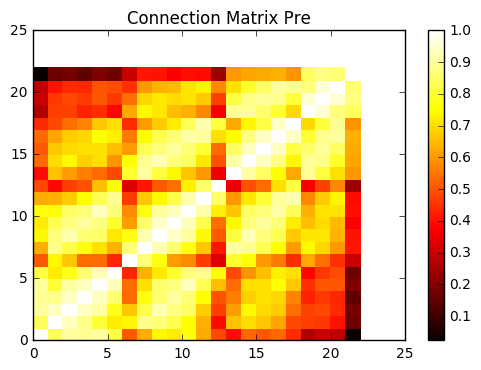

In [12]:
plt.set_cmap('hot')
plt.pcolor(cm_pre.mean(axis=0))
plt.colorbar()
plt.title('Connection Matrix Pre')
plt.show()

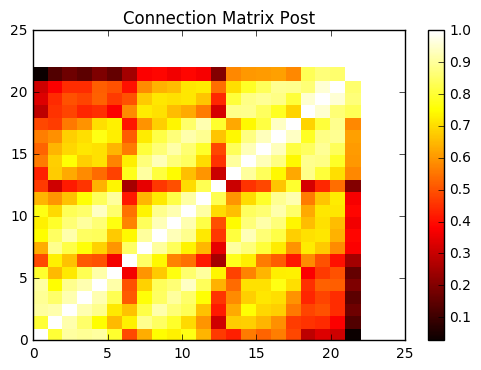

In [13]:
plt.set_cmap('hot')
plt.pcolor(cm.mean(axis=0))
plt.colorbar()
plt.title('Connection Matrix Post')
plt.show()

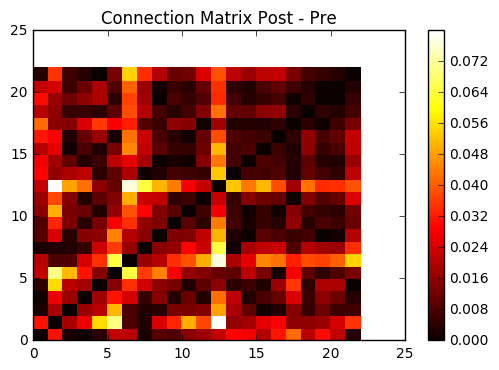

In [14]:
plt.set_cmap('hot')
plt.pcolor(np.abs(cm.mean(axis=0) - cm_pre.mean(axis=0)))
plt.colorbar()
plt.title('Connection Matrix Post - Pre')
plt.show()

フィッシャーのz変換 相関係数を正規分布するように変換
![fisherz](http://www.sist.ac.jp/~kanakubo/research/statistic/soukankeisuu9.png)

In [15]:
def fisher_z(r, n):
    z = 0.5*np.log((1+r)/(1-r))
    return z

相関係数の差の検定

参考サイト [http://www.koka.ac.jp/morigiwa/sjs/correlation_difference.htm](http://www.koka.ac.jp/morigiwa/sjs/correlation_difference.htm)

In [16]:
def cor_diff_test(r1, r2, n1, n2):
    z1 = fisher_z(r1, n1)
    z2 = fisher_z(r2, n2)
    z = (z1 - z2)/(np.sqrt(1/(n1-3) + 1/(n2-3)))
    p_value = norm.sf(abs(z))*2
    return p_value

In [18]:
p_values = []
for i in range(22):
    for j in range(22):
        if i >= j:
            continue
        p_value = cor_diff_test(cm.mean(axis=0)[i,j], cm_pre.mean(axis=0)[i,j], 1500, 1500)
        print("ch{0}: ch{1} p_value:{2}".format(i+1,j+1,p_value))
        p_values.append(p_value)

ch1: ch2 p_value:0.009001111444637035
ch1: ch3 p_value:0.7505044266728287
ch1: ch4 p_value:0.9097785895746977
ch1: ch5 p_value:0.5138155646607121
ch1: ch6 p_value:0.08496676960687578
ch1: ch7 p_value:0.45100604211732465
ch1: ch8 p_value:0.9237034052274873
ch1: ch9 p_value:0.5731117225909302
ch1: ch10 p_value:0.6312060192027723
ch1: ch11 p_value:0.32427548428823516
ch1: ch12 p_value:0.42252942510626235
ch1: ch13 p_value:0.4365551635817485
ch1: ch14 p_value:0.33057124576290564
ch1: ch15 p_value:0.27180930444508555
ch1: ch16 p_value:0.45469776184004895
ch1: ch17 p_value:0.21627891884702632
ch1: ch18 p_value:0.14365886774373965
ch1: ch19 p_value:0.5362086617890167
ch1: ch20 p_value:0.35611793336475084
ch1: ch21 p_value:0.5083072485666598
ch1: ch22 p_value:0.9283090969789621
ch2: ch3 p_value:0.00018380893551632523
ch2: ch4 p_value:0.0026132343650595927
ch2: ch5 p_value:0.00013000252684206118
ch2: ch6 p_value:0.0002608991506719306
ch2: ch7 p_value:0.6317879126794688
ch2: ch8 p_value:0.724542

In [19]:
np.where(np.array(p_values) < 0.05)

(array([  0,  21,  22,  23,  24,  27,  28,  29,  31,  41,  42,  43,  60,
         61,  78,  95,  97,  98, 100, 116, 126, 130, 132, 140, 141, 176, 189]),)

相関行列のすべての値に対して相関係数の検定を行う場合は、検定回数が多いことによる偶然の帰無仮設棄却を避けるため[FDR](https://www.slideshare.net/yuifu/fdr-kashiwar-3)などにより棄却水準を随時調整する必要がある

In [20]:
reject, pvals,_,_ = multipletests(p_values)

In [21]:
cnt = 0
for i in range(22):
    for j in range(22):
        if i >= j:
            continue
        if(reject[cnt]):
            print("ch{0}: ch{1} significant p_value:{2}".format(i,j,p_values[cnt]))
            cnt += 1

### 右手

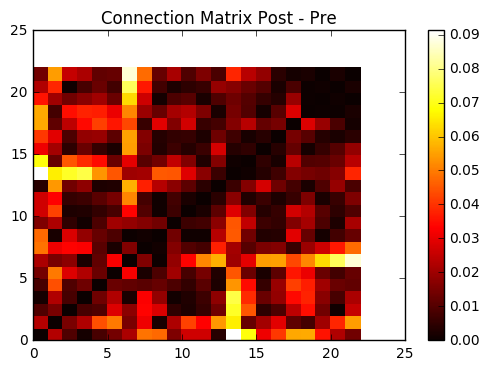

ch1: ch2 p_value:0.05703400293427473
ch1: ch3 p_value:0.1586942256926911
ch1: ch4 p_value:0.81787126001844
ch1: ch5 p_value:0.19466091058310275
ch1: ch6 p_value:0.24702870119366005
ch1: ch7 p_value:0.4199304954328601
ch1: ch8 p_value:0.023610417004549106
ch1: ch9 p_value:0.004024178404774785
ch1: ch10 p_value:0.35778019575708697
ch1: ch11 p_value:0.0826755951260547
ch1: ch12 p_value:0.22118380560859108
ch1: ch13 p_value:0.8839053700056536
ch1: ch14 p_value:0.001857237880104942
ch1: ch15 p_value:0.005873839213350421
ch1: ch16 p_value:0.23943831242233726
ch1: ch17 p_value:0.11053000275840688
ch1: ch18 p_value:0.05513022171883008
ch1: ch19 p_value:0.0899475583765278
ch1: ch20 p_value:0.2716273926937437
ch1: ch21 p_value:0.5010927796524056
ch1: ch22 p_value:0.6981582757791789
ch2: ch3 p_value:0.004386180575163471
ch2: ch4 p_value:0.01230406553095024
ch2: ch5 p_value:0.0028566250613961046
ch2: ch6 p_value:0.009760075264801767
ch2: ch7 p_value:0.35531407467657694
ch2: ch8 p_value:3.668090595

(array([  6,   7,  12,  13,  21,  22,  23,  24,  26,  29,  32,  45,  46,
         51,  52,  60,  61,  63,  69,  70,  78,  86,  87,  90, 100, 119,
        120, 122, 123, 124, 125, 131, 140, 144, 145, 156, 157, 171, 216]),)

In [23]:
cm = make_connection_matrix(epochs['right_hand'].get_data()[:,0:22,750:1250])
cm_pre = make_connection_matrix(epochs['right_hand'].get_data()[:,0:22,0:500])
plt.set_cmap('hot')
plt.pcolor(np.abs(cm.mean(axis=0) - cm_pre.mean(axis=0)))
plt.colorbar()
plt.title('Connection Matrix Post - Pre')
plt.show()
p_values = []
for i in range(22):
    for j in range(22):
        if i >= j:
            continue
        p_value = cor_diff_test(cm.mean(axis=0)[i,j], cm_pre.mean(axis=0)[i,j], 1500, 1500)
        print("ch{0}: ch{1} p_value:{2}".format(i+1,j+1,p_value))
        p_values.append(p_value)
np.where(np.array(p_values) < 0.05)

### 足

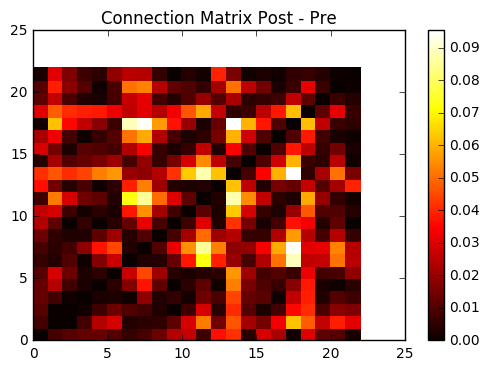

ch1: ch2 p_value:0.5017073584778655
ch1: ch3 p_value:0.10305629202465683
ch1: ch4 p_value:0.06471410377826584
ch1: ch5 p_value:0.04558409415345842
ch1: ch6 p_value:0.38606521013344597
ch1: ch7 p_value:0.8282896710003924
ch1: ch8 p_value:0.6926319284895677
ch1: ch9 p_value:0.3906388819266494
ch1: ch10 p_value:0.16821566601829208
ch1: ch11 p_value:0.09730924903751834
ch1: ch12 p_value:0.7391218055471436
ch1: ch13 p_value:0.20480711366035032
ch1: ch14 p_value:0.1851016080392779
ch1: ch15 p_value:0.8746959895856772
ch1: ch16 p_value:0.28255988903022833
ch1: ch17 p_value:0.3965073432375942
ch1: ch18 p_value:0.9626538872368995
ch1: ch19 p_value:0.3783333369648041
ch1: ch20 p_value:0.7248970296781523
ch1: ch21 p_value:0.7589407552487604
ch1: ch22 p_value:0.9557864138527891
ch2: ch3 p_value:0.9595651175392472
ch2: ch4 p_value:0.3762196446178657
ch2: ch5 p_value:0.09080026745116078
ch2: ch6 p_value:0.11923441350371626
ch2: ch7 p_value:0.8238393815094626
ch2: ch8 p_value:0.584974581738493
ch2: c

(array([  3,  30,  32,  36,  96, 115, 121, 127, 128, 129, 131, 132, 133,
        134, 135, 138, 141, 142, 148, 154, 156, 160, 167, 168, 172, 177,
        178, 179, 182, 196, 197, 198, 201, 203, 204, 205, 210, 211, 212,
        216, 217, 221, 222, 225, 226, 228]),)

In [25]:
cm = make_connection_matrix(epochs['feet'].get_data()[:,0:22,750:1250])
cm_pre = make_connection_matrix(epochs['feet'].get_data()[:,0:22,0:500])
plt.set_cmap('hot')
plt.pcolor(np.abs(cm.mean(axis=0) - cm_pre.mean(axis=0)))
plt.colorbar()
plt.title('Connection Matrix Post - Pre')
plt.show()
p_values = []
for i in range(22):
    for j in range(22):
        if i >= j:
            continue
        p_value = cor_diff_test(cm.mean(axis=0)[i,j], cm_pre.mean(axis=0)[i,j], 1500, 1500)
        print("ch{0}: ch{1} p_value:{2}".format(i+1,j+1,p_value))
        p_values.append(p_value)
np.where(np.array(p_values) < 0.05)

### 舌

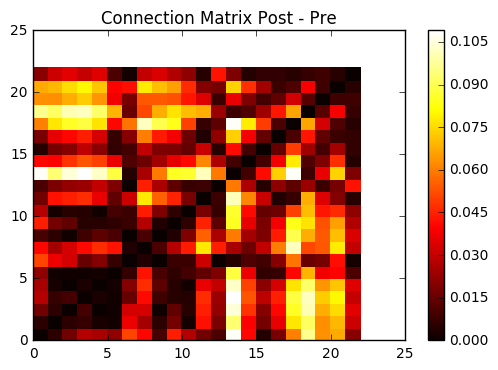

ch1: ch2 p_value:0.6161609271415349
ch1: ch3 p_value:0.014881504225078897
ch1: ch4 p_value:5.551063537652309e-05
ch1: ch5 p_value:8.12098512099774e-05
ch1: ch6 p_value:0.06423500451387781
ch1: ch7 p_value:0.06727431383987957
ch1: ch8 p_value:0.07335265548412097
ch1: ch9 p_value:0.5368794509561798
ch1: ch10 p_value:0.009494955957170325
ch1: ch11 p_value:0.07630951882144661
ch1: ch12 p_value:0.46308776922516637
ch1: ch13 p_value:0.7168370340547687
ch1: ch14 p_value:0.000659142481721761
ch1: ch15 p_value:0.1254135295460141
ch1: ch16 p_value:0.8672220414313347
ch1: ch17 p_value:0.4888104030632274
ch1: ch18 p_value:0.044428677471449594
ch1: ch19 p_value:0.005086722620914462
ch1: ch20 p_value:0.05874899925173268
ch1: ch21 p_value:0.047934796699369384
ch1: ch22 p_value:0.5704832705287484
ch2: ch3 p_value:0.2305549791463457
ch2: ch4 p_value:0.38586528568160183
ch2: ch5 p_value:0.8612448442837182
ch2: ch6 p_value:0.9353470592098874
ch2: ch7 p_value:0.032763800756240025
ch2: ch8 p_value:0.003834

(array([  1,   2,   3,   8,  12,  16,  17,  19,  25,  26,  32,  33,  36,
         37,  38,  39,  41,  45,  49,  51,  52,  54,  55,  56,  57,  58,
         63,  67,  69,  70,  72,  73,  74,  75,  76,  80,  84,  86,  87,
         89,  90,  91,  92,  93, 102, 106, 107, 127, 128, 129, 131, 133,
        134, 135, 136, 137, 138, 141, 142, 144, 145, 146, 147, 148, 149,
        150, 151, 154, 156, 157, 158, 159, 160, 161, 162, 163, 165, 167,
        168, 170, 171, 172, 173, 174, 177, 178, 179, 182, 196, 197, 198,
        200, 201, 204, 205, 207, 208, 210, 211, 212, 214, 216, 217, 221,
        222, 225, 226, 228]),)

In [27]:
cm = make_connection_matrix(epochs['tongue'].get_data()[:,0:22,750:1250])
cm_pre = make_connection_matrix(epochs['tongue'].get_data()[:,0:22,0:500])
plt.set_cmap('hot')
plt.pcolor(np.abs(cm.mean(axis=0) - cm_pre.mean(axis=0)))
plt.colorbar()
plt.title('Connection Matrix Post - Pre')
plt.show()
p_values = []
for i in range(22):
    for j in range(22):
        if i >= j:
            continue
        p_value = cor_diff_test(cm.mean(axis=0)[i,j], cm_pre.mean(axis=0)[i,j], 1500, 1500)
        print("ch{0}: ch{1} p_value:{2}".format(i+1,j+1,p_value))
        p_values.append(p_value)
np.where(np.array(p_values) < 0.05)

### 今後に向けて
+ 被験者全体でPreとPostに差が見られるかを調べる
    + 単純に足しあわせて平均を出すだけでいいのか、マルチレベルの分析が必要になるのか
+ 特定の周波数帯域に絞ってチャンネル間のコネクションを見る
    + α帯(8-13Hz)やβ帯(19-21Hz）に選択的に着目してチャンネル間のコネクションをみるアプローチもポピュラーである(例：[http://www.jneurosci.org/content/jneuro/35/4/1627.full.pdf](http://www.jneurosci.org/content/jneuro/35/4/1627.full.pdf))
    + 相関係数の代わりに[コヒーレンス](http://www.cygres.com/OcnPageJ/Glosry/CohJ.html)を用いる